# Moisture Magic 💦 🧙‍♂️
## Preprocessing of UFZ Dataset Soil Moisture "Hohes Holz" 📝 → 📦

HIDA 2020 Hackthon, 2020-11-05

In [1]:
import numpy as np
import pandas as pd
#import xarray as xr

In [2]:
import sys
sys.path.insert(0,'/p/home/jusers/merdian-tarko1/jusuf/lib/python3.6/site-packages')
import xarray as xr

In [3]:
# read raw data and convert datetime
df = pd.read_csv("/p/home/jusers/merdian-tarko1/jusuf/PROJECT_training2005/ufz_qc_challenge/00_data.csv", delim_whitespace=True)
df['Date.Time'] = pd.to_datetime(df['Date.Time'])
df.head(2)

,,Time,Box,Date.Time,SM1,SM1_Flag,Temp1,Temp1_Flag,SM2,SM2_Flag,Temp2,...,SM6_Flag,Temp6,Temp6_Flag,BattV,SM1_Depth,SM2_Depth,SM3_Depth,SM4_Depth,SM5_Depth,SM6_Depth
1.2,2012-07-19,17:45:53,1,2012-07-19 17:45:53,-2.8240,Auto:Range,18.2580,OK,-5.9817,Auto:Range,18.2232,...,Auto:Range,18.3623,OK,3599,0.05,0.05,0.05,0.05,0.05,0.05
2.2,2010-10-03,02:07:00,2,2010-10-03 02:07:00,29.9656,OK,5.0416,OK,-4.8066,Auto:Range,-15.1656,...,OK,5.7372,OK,3138,0.10,0.20,0.30,0.40,0.50,0.60


### 1. Initial cleanup

Steps:  
* drop columns not needed for analysis
* eliminate Box1 (located in first row) since it only has one measly measurement...
* rename some columns
* make time the index

In [4]:
df = df.reset_index().drop(['level_0','level_1','Time'], axis=1).iloc[1:,:]
df = df.rename(columns={'Box': 'box', 'Date.Time': 'time'})
df = df.set_index('time')
df.head(2)

,box,SM1,SM1_Flag,Temp1,Temp1_Flag,SM2,SM2_Flag,Temp2,Temp2_Flag,SM3,...,SM6_Flag,Temp6,Temp6_Flag,BattV,SM1_Depth,SM2_Depth,SM3_Depth,SM4_Depth,SM5_Depth,SM6_Depth
time,,,,,,,,,,,,,,,,,,,,,
2010-10-03 02:07:00,2,29.9656,OK,5.0416,OK,-4.8066,Auto:Range,-15.1656,OK,-7.6653,...,OK,5.7372,OK,3138,0.1,0.2,0.3,0.4,0.5,0.6
2010-10-03 03:07:00,2,26.1448,OK,8.4848,OK,23.7972,OK,7.7544,OK,125.1174,...,Auto:Spike,6.8154,OK,3496,0.1,0.2,0.3,0.4,0.5,0.6


### 2. Resample to consistent 15min intervals

In [5]:
df = df.groupby('box').resample('15min').first().drop('box', axis=1)

### 3. Reshape dataframe (wide to short form)

Steps:
* split into variable groups
* ignore depth (we use level for vertical stratification)
* rename columns to level id for later melt
* melt to narrow df form
* convert to xarray dataset

In [6]:
# split df for variable groups
def expand_name(var, flag=False):
    f = '_Flag' if flag else ''
    return [f"{var}{i}{f}" for i in range(1,7)]

df_sm = df[expand_name('SM')]
df_temp = df[expand_name('Temp')]
df_bat = df[['BattV']]

# and quality flags
df_sm_qa = df[expand_name('SM', flag=True)]
df_temp_qa = df[expand_name('Temp', flag=True)]

# rename columns
for d in [df_sm, df_temp, df_sm_qa, df_temp_qa]:
    d.columns = list(range(1,7))

# melt
df_sm = pd.melt(df_sm.reset_index(), id_vars=['box','time']).set_index(['time','box'])
df_temp = pd.melt(df_temp.reset_index(), id_vars=['box','time']).set_index(['time','box'])
df_sm_qa = pd.melt(df_sm_qa.reset_index(), id_vars=['box','time']).set_index(['time','box'])
df_temp_qa = pd.melt(df_temp_qa.reset_index(), id_vars=['box','time']).set_index(['time','box'])

# rename new columns
df_sm.columns = ['level', 'soilmoisture']
df_temp.columns = ['level', 'soiltemp']
df_sm_qa.columns = ['level', 'soilmoisture_flag']
df_temp_qa.columns = ['level', 'soiltemp_flag']

# add level to multi-index
df_sm = df_sm.set_index('level', append=True)
df_temp = df_temp.set_index('level', append=True)
df_sm_qa = df_sm_qa.set_index('level', append=True)
df_temp_qa = df_temp_qa.set_index('level', append=True)

# convert dtype of categorical columns
df_sm_qa['soilmoisture_flag'] = df_sm_qa['soilmoisture_flag'].astype('category')
df_temp_qa['soiltemp_flag'] = df_temp_qa['soiltemp_flag'].astype('category')

df_sm_qa.head(2)

,,,soilmoisture_flag
time,box,level,
2010-10-03 02:00:00,2,1,OK
2010-10-03 02:15:00,2,1,NaN


In [7]:
display(df_sm_qa['soilmoisture_flag'].cat.categories)
display(np.unique(df_sm_qa['soilmoisture_flag'].cat.codes))

Index(['Auto:BattV', 'Auto:Range', 'Auto:Spike', 'Manual', 'OK'], dtype='object')

array([-1,  0,  1,  2,  3,  4], dtype=int8)

### 4. Convert to xarray dataset

In [8]:
ds = pd.concat([df_sm, df_temp, df_sm_qa, df_temp_qa], axis=1).to_xarray()

ds['soiltemp'].attrs['long_name'] = "soil temperature"
ds['soiltemp'].attrs['units'] = "deg C"
ds['soilmoisture'].attrs['long_name'] = "soil moisture"
ds['soilmoisture'].attrs['units'] = "vol percent"

ds['soiltemp_flag'].attrs['long_name'] = "soil temperature qa flag"
ds['soiltemp_flag'].attrs['units'] = "category"
ds['soiltemp_flag'].attrs['flag_values'] = ','.join([str(x) for x in np.unique(df_temp_qa['soiltemp_flag'].cat.codes.values)[1:]])
ds['soiltemp_flag'].attrs['flag_meanings'] = ' '.join(df_temp_qa['soiltemp_flag'].cat.categories.values.tolist())
   
ds['soilmoisture_flag'].attrs['long_name'] = "soil moisture qa flag"
ds['soilmoisture_flag'].attrs['units'] = "category"
ds['soilmoisture_flag'].attrs['flag_values'] = ','.join([str(x) for x in np.unique(df_sm_qa['soilmoisture_flag'].cat.codes.values)[1:]])
ds['soilmoisture_flag'].attrs['flag_meanings'] = ' '.join(df_sm_qa['soilmoisture_flag'].cat.categories.values.tolist())


ds

<xarray.Dataset>
Dimensions:            (box: 39, level: 6, time: 302043)
Coordinates:
  * time               (time) datetime64[ns] 2010-09-30T02:00:00 ... 2019-05-...
  * box                (box) int64 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * level              (level) int64 1 2 3 4 5 6
Data variables:
    soilmoisture       (time, box, level) float64 nan nan nan ... -13.3 45.43
    soiltemp           (time, box, level) float64 nan nan nan ... -15.55 7.928
    soilmoisture_flag  (time, box, level) object nan nan ... 'Manual'
    soiltemp_flag      (time, box, level) object nan nan nan ... 'Manual' 'OK'

In [9]:
df_bat = df[['BattV']]
df_bat = df_bat.reset_index()
df_bat.columns = ['box', 'time','battery']
df_bat = df_bat.set_index(['time', 'box'])
ds_bat = df_bat.to_xarray()

ds_bat.attrs['long_name'] = "battery voltage"
ds_bat.attrs['units'] = "mV"

ds_bat

<xarray.Dataset>
Dimensions:  (box: 39, time: 302043)
Coordinates:
  * time     (time) datetime64[ns] 2010-09-30T02:00:00 ... 2019-05-12T08:30:00
  * box      (box) int64 2 3 4 5 6 7 8 9 10 11 ... 31 32 33 34 35 36 37 38 39 40
Data variables:
    battery  (time, box) float64 nan nan nan ... 3.47e+03 3.248e+03 3.392e+03
Attributes:
    long_name:  battery voltage
    units:      mV

In [10]:
ds = xr.merge([ds, ds_bat])
ds

<xarray.Dataset>
Dimensions:            (box: 39, level: 6, time: 302043)
Coordinates:
  * time               (time) datetime64[ns] 2010-09-30T02:00:00 ... 2019-05-...
  * box                (box) int64 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * level              (level) int64 1 2 3 4 5 6
Data variables:
    soilmoisture       (time, box, level) float64 nan nan nan ... -13.3 45.43
    soiltemp           (time, box, level) float64 nan nan nan ... -15.55 7.928
    soilmoisture_flag  (time, box, level) object nan nan ... 'Manual'
    soiltemp_flag      (time, box, level) object nan nan nan ... 'Manual' 'OK'
    battery            (time, box) float64 nan nan nan ... 3.248e+03 3.392e+03

In [11]:
#ds.to_netcdf("ufz_hohes-holz.nc")

In [12]:
#! ls -lh

## Viz

In [13]:
import gc

In [14]:
gc.collect()

0

In [15]:
import matplotlib.pyplot as plt

### 1 examplary box time series

In [16]:
df = ds.to_dataframe().reset_index()

In [17]:
df.shape

(70678062, 8)

In [18]:
df.head()

,box,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
0,2,1,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
1,2,1,2010-09-30 02:15:00,NaN,NaN,NaN,NaN,NaN
2,2,1,2010-09-30 02:30:00,NaN,NaN,NaN,NaN,NaN
3,2,1,2010-09-30 02:45:00,NaN,NaN,NaN,NaN,NaN
4,2,1,2010-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN


In [33]:
df[df['soilmoisture'].notna()].groupby('box').agg({'time': ['min', 'max']})

time                    
                    min                 max
box                                        
2   2010-10-03 02:00:00 2016-03-22 04:30:00
3   2010-10-03 02:00:00 2016-03-03 10:15:00
4   2010-10-05 16:00:00 2019-05-12 08:30:00
5   2012-07-19 20:45:00 2013-12-01 07:45:00
6   2010-09-30 02:00:00 2019-05-12 08:30:00
7   2010-10-03 02:00:00 2019-05-12 08:30:00
8   2010-09-30 02:00:00 2014-02-27 02:00:00
9   2012-07-19 19:45:00 2013-08-09 16:30:00
10  2012-07-19 19:30:00 2016-03-17 04:00:00
11  2010-10-03 04:00:00 2015-10-13 06:30:00
12  2010-10-05 11:00:00 2017-01-30 14:45:00
13  2010-09-30 03:00:00 2019-05-12 08:30:00
14  2012-07-19 19:45:00 2016-07-26 23:30:00
15  2012-07-19 19:45:00 2019-05-12 08:30:00
16  2010-10-03 14:00:00 2016-10-02 00:00:00
17  2012-07-19 19:45:00 2016-09-30 14:00:00
18  2012-07-19 18:30:00 2016-04-27 21:00:00
19  2012-07-24 16:15:00 2013-12-12 10:00:00
20  2010-10-02 21:00:00 2016-11-17 15:30:00
21  2012-07-19 18:15:00 2016-12-31 19:15:00
22  2012-07-19 17:30:00 2017-03-24 01:00:00
23  2012-07-19 17:15:00 2017-05-16 13:00:00
24  2012-07-19 18:30:00 2019-05-12 08:30:00
25  2012-07-19 17:30:00 2017-03-29 07:45:00
26  2010-10-03 00:00:00 2019-05-12 08:30:00
27  2010-10-12 01:00:00 2019-05-12 08:30:00
28  2012-07-19 18:45:00 2017-03-16 08:00:00
29  2012-07-19 20:15:00 2019-05-12 08:30:00
30  2012-07-24 16:30:00 2016-02-21 06:00:00
31  2012-07-19 17:45:00 2017-01-11 21:15:00
32  2012-07-19 18:15:00 2017-04-06 09:00:00
33  2010-10-03 15:00:00 2016-03-30 07:30:00
34  2010-10-03 03:00:00 2019-05-12 08:30:00
35  2010-09-30 03:00:00 2019-05-12 08:30:00
36  2012-07-19 18:30:00 2019-05-12 08:30:00
37  2010-10-05 16:00:00 2019-05-12 08:30:00
38  2010-10-03 02:00:00 2019-05-12 08:30:00
39  2013-06-06 13:00:00 2019-05-12 08:30:00
40  2013-06-25 10:45:00 2019-05-12 08:30:00

In [60]:
df[df['soilmoisture'].isna()].groupby('box').count()

,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
box,,,,,,,
2,1122051,1122051,0,3807,3807,3807,3807
3,1161473,1161473,0,39677,39677,39677,39677
4,764574,764574,0,187506,187506,187506,187506
5,1558974,1558974,0,156,156,156,156
6,722423,722423,0,35891,35891,35891,35891
7,569413,569413,0,33181,33181,33181,33181
8,1524342,1524342,0,36,36,36,36
9,1627204,1627204,0,2338,2338,2338,2338
10,1258657,1258657,0,123541,123541,123541,123541


In [50]:
box = df[df['box'] == 13].sort_values(by=['time', 'level'])

In [51]:
box.shape

(1812258, 8)

In [52]:
box.head()

,box,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
19934838,13,1,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
20236881,13,2,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
20538924,13,3,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
20840967,13,4,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
21143010,13,5,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN


In [53]:
box.tail()

,box,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
20538923,13,2,2019-05-12 08:30:00,4.9951,8.6935,Auto:Range,Manual,3511.0
20840966,13,3,2019-05-12 08:30:00,30.8076,0.1028,Manual,Manual,3511.0
21143009,13,4,2019-05-12 08:30:00,-12.8111,-16.2438,Auto:Range,Manual,3511.0
21445052,13,5,2019-05-12 08:30:00,-3.8618,-9.4269,Auto:Range,Manual,3511.0
21747095,13,6,2019-05-12 08:30:00,30.0290,8.1022,OK,OK,3511.0


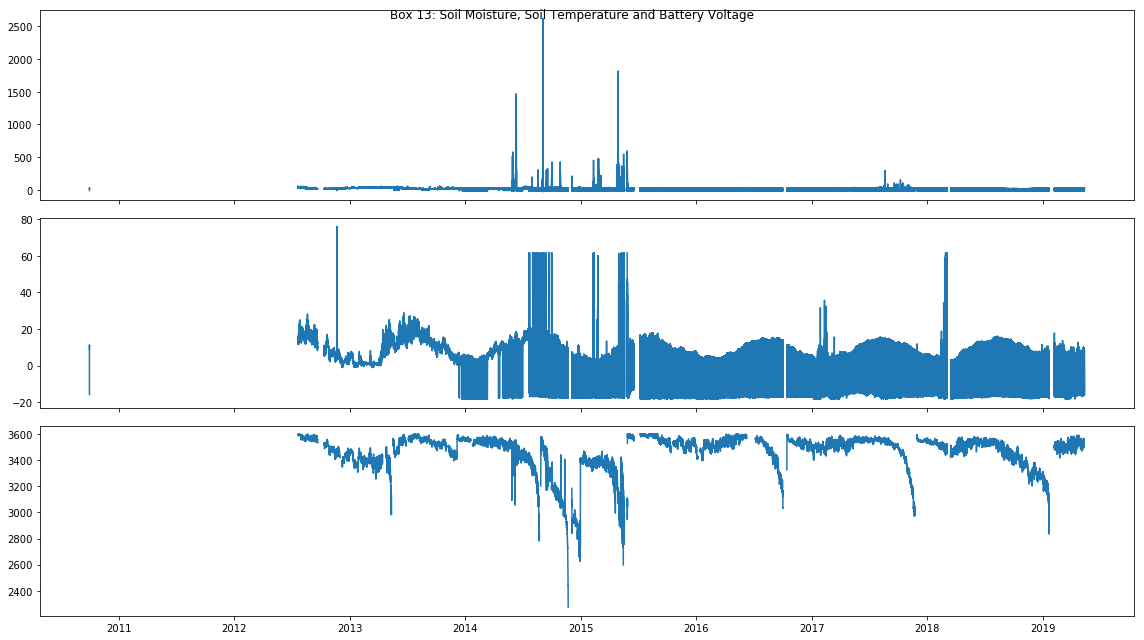

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(16,9))

fig.suptitle('Box 13: Soil Moisture, Soil Temperature and Battery Voltage')
ax1.plot(box.time, box.soilmoisture)
ax2.plot(box.time, box.soiltemp)
ax3.plot(box.time, box.battery)

fig.tight_layout()
plt.show()

## soil moisture

In [17]:
df = ds.to_dataframe().reset_index()

In [18]:
df.shape

(70678062, 8)

In [19]:
df.head()

,box,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
0,2,1,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
1,2,1,2010-09-30 02:15:00,NaN,NaN,NaN,NaN,NaN
2,2,1,2010-09-30 02:30:00,NaN,NaN,NaN,NaN,NaN
3,2,1,2010-09-30 02:45:00,NaN,NaN,NaN,NaN,NaN
4,2,1,2010-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.soilmoisture_flag.unique()

In [20]:
df.soilmoisture_flag = df.soilmoisture_flag.fillna('Missing')

In [21]:
df = pd.get_dummies(df, columns=['soilmoisture_flag'])

In [22]:
df.shape

(70678062, 13)

In [23]:
df.head()

,box,level,time,soilmoisture,soiltemp,soiltemp_flag,battery,soilmoisture_flag_Auto:BattV,soilmoisture_flag_Auto:Range,soilmoisture_flag_Auto:Spike,soilmoisture_flag_Manual,soilmoisture_flag_Missing,soilmoisture_flag_OK
0,2,1,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
1,2,1,2010-09-30 02:15:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
2,2,1,2010-09-30 02:30:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
3,2,1,2010-09-30 02:45:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
4,2,1,2010-09-30 03:00:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0


In [30]:
#df_agg = df[['time', 'soilmoisture_flag_Auto:BattV', 'soilmoisture_flag_Auto:Range', 'soilmoisture_flag_Auto:Spike', 'soilmoisture_flag_Manual', 'soilmoisture_flag_Missing', 'soilmoisture_flag_OK']].set_index('time').resample('M').sum()
df_agg = df[['time', 'soilmoisture_flag_Auto:BattV', 'soilmoisture_flag_Auto:Range', 'soilmoisture_flag_Auto:Spike', 'soilmoisture_flag_Manual', 'soilmoisture_flag_Missing', 'soilmoisture_flag_OK']].set_index('time').resample('Y').sum()

In [31]:
df_agg.shape

(10, 6)

In [32]:
df_agg.head()

,soilmoisture_flag_Auto:BattV,soilmoisture_flag_Auto:Range,soilmoisture_flag_Auto:Spike,soilmoisture_flag_Manual,soilmoisture_flag_Missing,soilmoisture_flag_OK
time,,,,,,
2010-12-31,36.0,1204.0,552.0,0.0,2080038.0,5450.0
2011-12-31,0.0,366.0,219.0,0.0,8197080.0,1695.0
2012-12-31,0.0,55283.0,39504.0,0.0,5585976.0,2541061.0
2013-12-31,28494.0,296965.0,46672.0,103405.0,1931154.0,5792670.0
2014-12-31,354120.0,1019652.0,28034.0,531482.0,1701906.0,4564166.0


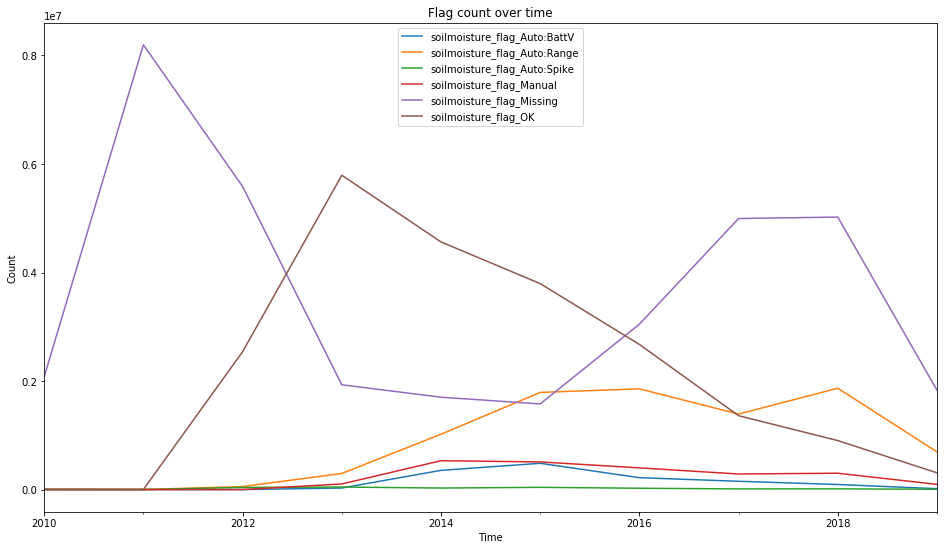

In [33]:
df_agg.plot(figsize=(16,9))
plt.title('Flag count over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

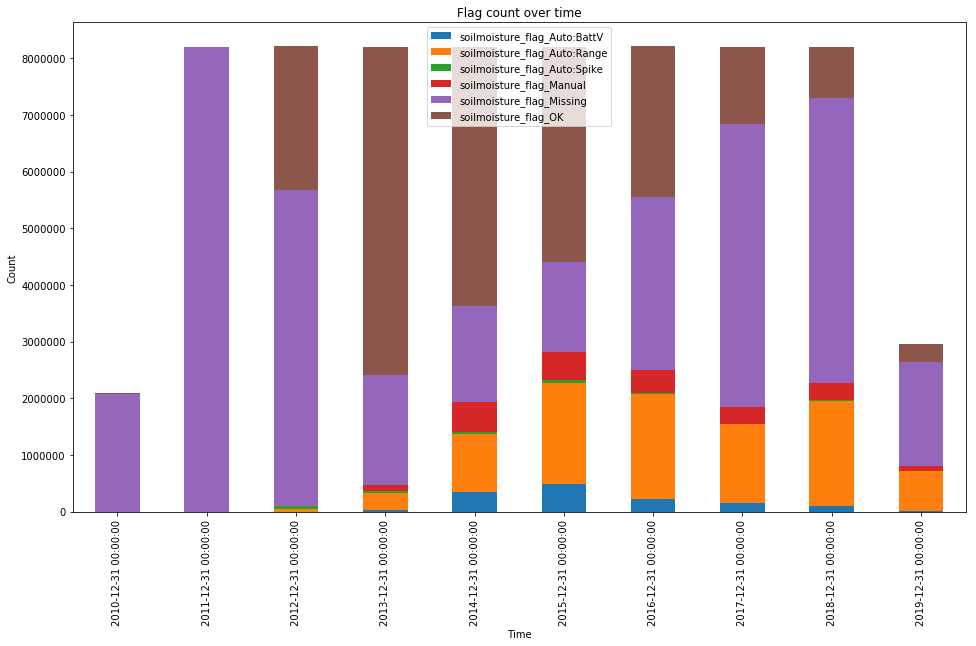

In [34]:
df_agg.plot(kind='bar', stacked=True, figsize=(16,9))
plt.title('Flag count over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

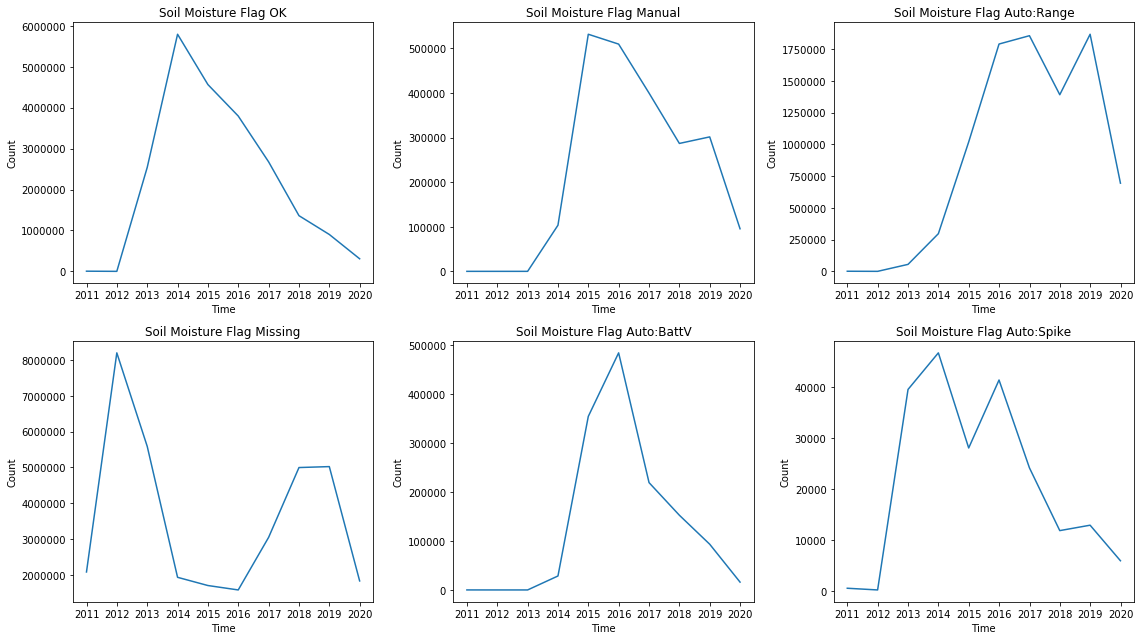

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))

x = df_agg.index

axs[0, 0].plot(x, df_agg['soilmoisture_flag_OK'])
axs[0, 0].set_title('Soil Moisture Flag OK')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Count')

axs[1, 0].plot(x, df_agg['soilmoisture_flag_Missing'])
axs[1, 0].set_title('Soil Moisture Flag Missing')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Count')

axs[0, 1].plot(x, df_agg['soilmoisture_flag_Manual'])
axs[0, 1].set_title('Soil Moisture Flag Manual')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Count')

axs[1, 1].plot(x, df_agg['soilmoisture_flag_Auto:BattV'])
axs[1, 1].set_title('Soil Moisture Flag Auto:BattV')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Count')

axs[0, 2].plot(x, df_agg['soilmoisture_flag_Auto:Range'])
axs[0, 2].set_title('Soil Moisture Flag Auto:Range')
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Count')

axs[1, 2].plot(x, df_agg['soilmoisture_flag_Auto:Spike'])
axs[1, 2].set_title('Soil Moisture Flag Auto:Spike')
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Count')

fig.tight_layout()

## soil temperature

In [45]:
df = ds.to_dataframe().reset_index()

In [46]:
df.shape

(70678062, 8)

In [47]:
df.head()

,box,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
0,2,1,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
1,2,1,2010-09-30 02:15:00,NaN,NaN,NaN,NaN,NaN
2,2,1,2010-09-30 02:30:00,NaN,NaN,NaN,NaN,NaN
3,2,1,2010-09-30 02:45:00,NaN,NaN,NaN,NaN,NaN
4,2,1,2010-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN


In [48]:
df.soiltemp_flag.unique()

array([nan, 'OK', 'Auto:Spike', 'Auto:Range', 'Manual', 'Auto:BattV'],
      dtype=object)

In [49]:
df.soiltemp_flag = df.soiltemp_flag.fillna('Missing')

In [50]:
df = pd.get_dummies(df, columns=['soiltemp_flag'])

In [51]:
df.shape

(70678062, 13)

In [52]:
df.head()

,box,level,time,soilmoisture,soiltemp,soilmoisture_flag,battery,soiltemp_flag_Auto:BattV,soiltemp_flag_Auto:Range,soiltemp_flag_Auto:Spike,soiltemp_flag_Manual,soiltemp_flag_Missing,soiltemp_flag_OK
0,2,1,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
1,2,1,2010-09-30 02:15:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
2,2,1,2010-09-30 02:30:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
3,2,1,2010-09-30 02:45:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0
4,2,1,2010-09-30 03:00:00,NaN,NaN,NaN,NaN,0,0,0,0,1,0


In [53]:
#df_agg = df[['time', 'soiltemp_flag_Auto:BattV', 'soiltemp_flag_Auto:Range', 'soiltemp_flag_Auto:Spike', 'soiltemp_flag_Manual', 'soiltemp_flag_Missing', 'soiltemp_flag_OK']].set_index('time').resample('M').sum()
df_agg = df[['time', 'soiltemp_flag_Auto:BattV', 'soiltemp_flag_Auto:Range', 'soiltemp_flag_Auto:Spike', 'soiltemp_flag_Manual', 'soiltemp_flag_Missing', 'soiltemp_flag_OK']].set_index('time').resample('Y').sum()

In [54]:
df_agg.shape

(10, 6)

In [55]:
df_agg.head()

,soiltemp_flag_Auto:BattV,soiltemp_flag_Auto:Range,soiltemp_flag_Auto:Spike,soiltemp_flag_Manual,soiltemp_flag_Missing,soiltemp_flag_OK
time,,,,,,
2010-12-31,36.0,354.0,991.0,0.0,2080038.0,5861.0
2011-12-31,0.0,107.0,277.0,0.0,8197080.0,1896.0
2012-12-31,0.0,6663.0,24956.0,0.0,5585976.0,2604229.0
2013-12-31,28494.0,23073.0,59992.0,65546.0,1931154.0,6091101.0
2014-12-31,354120.0,222629.0,49177.0,830818.0,1701906.0,5040710.0


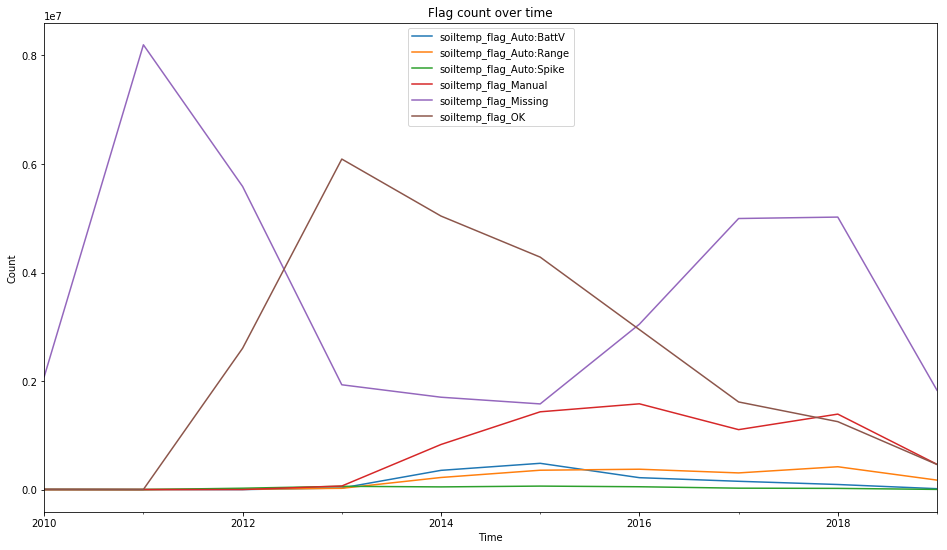

In [56]:
df_agg.plot(figsize=(16,9))
plt.title('Flag count over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

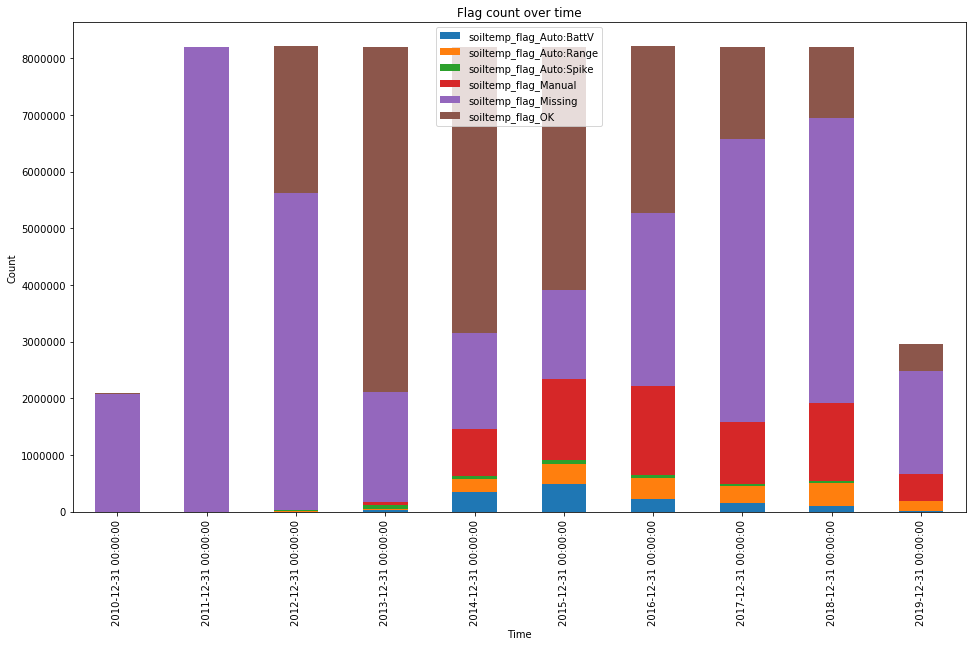

In [57]:
df_agg.plot(kind='bar', stacked=True, figsize=(16,9))
plt.title('Flag count over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

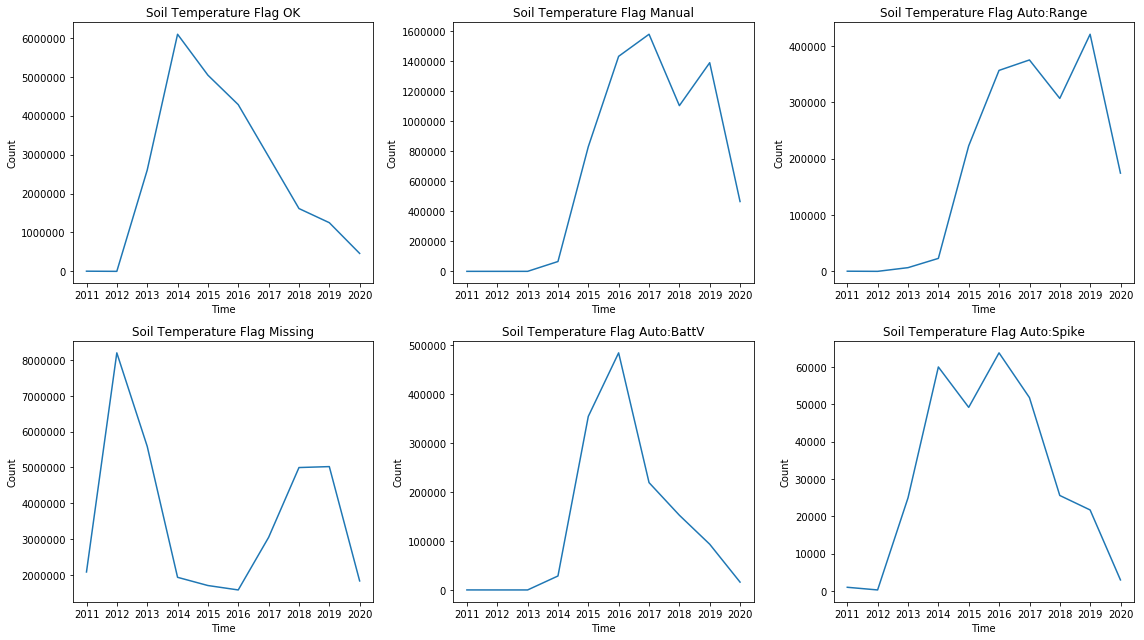

In [59]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))

x = df_agg.index

axs[0, 0].plot(x, df_agg['soiltemp_flag_OK'])
axs[0, 0].set_title('Soil Temperature Flag OK')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Count')

axs[1, 0].plot(x, df_agg['soiltemp_flag_Missing'])
axs[1, 0].set_title('Soil Temperature Flag Missing')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Count')

axs[0, 1].plot(x, df_agg['soiltemp_flag_Manual'])
axs[0, 1].set_title('Soil Temperature Flag Manual')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Count')

axs[1, 1].plot(x, df_agg['soiltemp_flag_Auto:BattV'])
axs[1, 1].set_title('Soil Temperature Flag Auto:BattV')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Count')

axs[0, 2].plot(x, df_agg['soiltemp_flag_Auto:Range'])
axs[0, 2].set_title('Soil Temperature Flag Auto:Range')
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Count')

axs[1, 2].plot(x, df_agg['soiltemp_flag_Auto:Spike'])
axs[1, 2].set_title('Soil Temperature Flag Auto:Spike')
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Count')

fig.tight_layout()